# Семинар 6 - A Diffusion Model from Scratch in Pytorch


*Материалы основаны на:*
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)
- [Lilian blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

Рассмотрим **Denoising Diffusion Probabilistic Models** (также известные как DDPMs, диффузионные модели, генеративные модели на основе оценок или просто [автокодеры](https://benanne.github.io/2022/01/31/diffusion.html)). поскольку исследователи смогли добиться с их помощью замечательных результатов для (не) условного изображения/генерация аудио/ видео. Популярные примеры (на момент написания статьи) включают [GLIDE](https://arxiv.org/abs/2112.10741) и [DALL-E 2](https://openai.com/dall-e-2) с помощью OpenAI, [Скрытая диффузия](https://github.com/CompVis/latent-diffusion) Гейдельбергским университетом и [ImageGen](https://imagen.research.google/).

Мы рассмотрим оригинальную статью DDPM от ([Ho et al., 2020](https://arxiv.org/abs/2006.11239)), реализуя это шаг за шагом в PyTorch, основываясь на [реализации](https://github.com/lucidrains/denoising-diffusion-pytorch) Фила Вана - который сам по себе основан на [оригинальной реализации TensorFlow](https://github.com/hojonathanho/diffusion). Обратите внимание, что идея диффузии для генеративного моделирования фактически уже была представлена в ([Sohl-Dickstein et al., 2015](https://arxiv.org/abs/1503.03585)). Однако это продолжалось до тех пор, пока ([Song et al., 2019](https://arxiv.org/abs/1907.05600)) (в Стэнфордском университете), а затем ([Хо и др., 2020](https://arxiv.org/abs/2006.11239)) (Google Brain), который независимо улучшил этот подход.

Здесь мы используем перспективу дискретного времени (модель скрытой переменной).

In [22]:
import math

import numpy as np
import matplotlib.pyplot as plt


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torch.optim import Adam

## Что такое диффузионная модель?

Диффузионная модель (шумоподавляющая) не так уж сложна, если сравнить ее с другими генеративными моделями, такими как нормализующие потоки, GANs или VAEs: все они преобразуют шум из некоторого простого распределения в выборку данных. Это также тот случай, когда **нейронная сеть учится постепенно уменьшать шум данных**, начиная с чистого шума. 

Если говорить немного подробнее об изображениях, то настройка состоит из 2 процессов:
* фиксированный (или предопределенный) процесс прямой диффузии $q$ по нашему выбору, который постепенно добавляет гауссов шум к изображению, пока вы не получите чистый шум
* изученный процесс диффузии с обратным шумоподавлением $ p_\theta$, при котором нейронная сеть обучается постепенному шумоподавлению изображения, начиная с чистого шума, пока в итоге не получится реальное изображение.


<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>


Как прямой, так и обратный процесс, индексируемый \\(t\\), выполняются за некоторое количество конечных временных шагов \\(T\\) (авторы DDPM используют \\(T=1000\\)). Вы начинаете с \\(t = 0\\), где вы отбираете реальное изображение \\(\mathbf{x}_0\\) из вашего распределения данных (скажем, изображение кошки из ImageNet), и прямой процесс отбирает некоторый шум из распределения Гаусса в каждом временной шаг \\(t\\), который добавляется к изображению предыдущего временного шага. Учитывая достаточно большой \\(T\\) и хорошо выполненный график добавления шума на каждом временном шаге, вы в конечном итоге получаете то, что называется [изотропным распределением Гаусса](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic ) при \\(t=T\\) с помощью постепенного процесса.

## В более математической форме

Давайте запишем это более формально, поскольку в конечном счете нам нужна управляемая функция потерь, которую наша нейронная сеть должна оптимизировать. 

Пусть \\(q(\mathbf{x}_0)\\) - реальное распределение данных, скажем, "реальных изображений". Мы можем сделать выборку из этого дистрибутива, чтобы получить изображение, \\(\mathbf{x}_0 \sim q(\mathbf{x}_0)\\). Мы определяем процесс прямой диффузии \\(q(\mathbf{x}_t | \mathbf{x}_{t-1})\\), который добавляет гауссов шум на каждом временном шаге \\ (t\\) в соответствии с известным графиком дисперсии \\(0 < \beta_1 < \beta_2 < ... < \beta_T < 1\\) как
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}). 
$$

Напомним, что нормальное распределение (также называемое распределением Гаусса) определяется 2 параметрами: средним \\(\mu\\) и дисперсией \\(\sigma ^2\geq 0\\). По сути, каждое новое (немного более шумное) изображение на временном шаге \\(t\\) извлекается из **условного распределения Гаусса** с помощью \\(\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}\\) и \\(\sigma ^ 2_t = \beta_t\\), что мы можем сделать, выбрав \\(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\) и затем установив \\(\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} + \sqrt{\beta_t} \mathbf{\epsilon}\\). 

Обратите внимание, что \\(\beta_t\\) не являются постоянными на каждом временном шаге \\(t\\) (отсюда и нижний индекс) -- фактически определяется так называемый **"график отклонений"**, который может быть линейным, квадратичным, косинусоидальным и т.д. как мы увидим далее (немного похоже на график скорости обучения). 

Итак, начиная с \\(\mathbf{x}_0\\), мы получаем \\(\mathbf{x}_1, ..., \mathbf{x}_t, ..., \mathbf{x}_T\\), где \\(\mathbf{x}_T\\) является чистым гауссовым шумом, если мы соответствующим образом настроим.

Теперь, если бы мы знали условное распределение \\(p(\mathbf{x}_{t-1} | \mathbf{x}_t)\\), тогда мы могли бы запустить процесс в обратном порядке: путем выборки некоторого случайного гауссова шума \\(\mathbf{x}_T\\), а затем постепенно "уменьшаем шум" так, чтобы в итоге мы получили выборку из реального распределения \\(\mathbf{x}_0\\).

Однако мы не знаем \\(p(\mathbf{x}_{t-1} | \mathbf{x}_t)\\). Это неразрешимо, поскольку для вычисления этой условной вероятности требуется знать распределение всех возможных изображений. Следовательно, мы собираемся использовать нейронную сеть для **аппроксимации (изучения) этого условного распределения вероятностей**, давайте назовем это \\(p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)\\), с \\(\theta\\) - параметры нейронной сети, обновляемые методом градиентного спуска.

Итак, нам нужна нейронная сеть для представления (условного) распределения вероятностей обратного процесса. Если мы предположим, что этот обратный процесс также является гауссовым, то напомним, что любое гауссово распределение определяется 2 параметрами:
* среднее значение, параметризованное \\(\mu_\theta\\);
* дисперсия, параметризованная \\(\Sigma_\theta\\);

таким образом, мы можем параметризовать процесс следующим образом 
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathcal{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
где среднее значение и дисперсия также зависят от уровня шума \\(t\\).

Следовательно, наша нейронная сеть должна изучать / представлять среднее значение и дисперсию. Однако авторы DDPM решили **сохранить дисперсию фиксированной и позволить нейронной сети только изучать (представлять) среднее значение \\ (\ mu_ \ theta\\) этого условного распределения вероятностей**. Из публикации:

> Сначала мы устанавливаем \\(\Sigma_\theta ( \mathbf{x}_t, t) = \sigma^2_t \mathbf{I}\\) в неподготовленные константы, зависящие от времени. Экспериментально как \\(\sigma ^ 2_t = \beta_t\\), так и \\(\sigma ^ 2_t = \tilde {\beta}_t \\) (см. статью) дали схожие результаты. 

Позже это было улучшено в [Improved diffusion models](https://openreview.net/pdf?id=-NEXDKk8gZ ) статья, где нейронная сеть также изучает дисперсию этого обратного процесса, помимо среднего значения.

Итак, мы продолжаем, предполагая, что нашей нейронной сети нужно только изучить / представить среднее значение этого условного распределения вероятностей.

## Определение целевой функции (путем повторной параметризации среднего значения)

Чтобы вывести целевую функцию для изучения среднего значения обратного процесса, авторы отмечают, что комбинацию \\(q\\) и \\(p_\theta\\) можно рассматривать как вариационный автокодер (VAE) [(Kingma et al., 2013)](https://arxiv.org/abs/1312.6114). Следовательно, **вариационная нижняя граница** (также называемая ELBO) может быть использована для минимизации отрицательного логарифмического правдоподобия по отношению к основной выборке истинных данных \\(\mathbf {x} _0 \\) (ссылаемся на статью VAE для получения подробной информации о ELBO). Получается, что ELBO для этого процесса представляет собой сумму потерь на каждом временном шаге \\(t\\), \\(L = L_0 + L_1 + ... + L_T\\). При построении прямого \\(q\\) процесса и обратного процесса каждый член (за исключением \\(L_0 \\)) потерь фактически представляет собой **расхождение KL между 2 гауссовскими распределениями**, которое может быть записано явно как L2-потеря.

Прямым следствием построенного прямого процесса \\(q\\), как показано Sohl-Dickstein и др., является то, что мы можем выполнять выборку \\(\mathbf{x}_t\\) при любом произвольном уровне шума, обусловленном \\(\mathbf{x}_0\\) (поскольку суммы гауссианов также являются гауссовыми). Это очень удобно: нам не нужно повторно применять \\(q\\), чтобы выполнить выборку \\(\mathbf{x}_t\\). 
У нас есть это 
$$q(\mathbf{x}_t | \mathbf{x}_0) = \cal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1- \bar{\alpha}_t) \mathbf{I})$$

с помощью \\(\alpha_t := 1 - \beta_t\\) и \\(\bar{\alpha}t := \Pi_{s=1}^{t} \alpha_s\\). Давайте назовем это уравнение "nice property". Это означает, что мы можем сэмплировать гауссов шум, соответствующим образом масштабировать его и добавлять в \\(\mathbf {x} _0 \\), чтобы получить \\(\mathbf {x} _t \\) напрямую. Обратите внимание, что \\(\bar{\alpha}_t\\) являются функциями известного графика дисперсии \\(\beta_t\\) и, следовательно, также известны и могут быть предварительно вычислены. Затем это позволяет нам во время обучения **оптимизировать случайные члены функции потерь \\(L\\)** (или, другими словами, произвольно выбирать \\(t\\) во время обучения и оптимизировать \\(L_t\\).

Еще одна прелесть этого свойства, как показано в работе Ho et al. заключается в том, что можно (после некоторой математики, приведенной в [этом превосходном блоге](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)) вместо этого **повторно параметризуется среднее значение, чтобы заставить нейронную сеть изучать (предсказывать) добавленный шум (через сеть \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) для уровня шума \\(t\\)** в терминах KL, которые составляют потери. Это означает, что наша нейронная сеть становится предиктором шума, а не (прямым) средним предиктором. Среднее значение может быть вычислено следующим образом:

$$ \mathbf{\mu}_\theta(\mathbf{x}_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{\beta_t}{\sqrt{1- \bar{\alpha}_t}} \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right)$$

Конечная целевая функция \\(L_t\\) затем выглядит следующим образом (для случайного временного шага \\(t\\), заданного \\(\mathbf{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})\\) ): 

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t) } \mathbf{\epsilon}, t) \|^2.$$

Здесь \\(\mathbf{x}_0\\) является исходным (реальным, не искаженным) изображением, и мы видим выборку прямого уровня шума \\(t\\), заданную фиксированным процессом прямой трансляции. \\(\mathbf{\epsilon}\\) - это чистый шум, дискретизированный на временном шаге \\(t\\), а \\(\mathbf{\epsilon}_\theta (\mathbf{x}_t, t)\\) - наша нейронная сеть. Нейронная сеть оптимизирована с использованием простой среднеквадратичной ошибки (MSE) между истинным и прогнозируемым гауссовым шумом.

Алгоритм обучения теперь выглядит следующим образом:


<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

**Таким образом:**
* мы берем случайную выборку $\mathbf{x}_0$ из реального неизвестного и, возможно, сложного распределения данных $q(\mathbf{x}_0)$
* мы выбираем уровень шума $t$ равномерно между $1$ и $T$ (т.е. случайный временной шаг)
* мы отбираем некоторый шум из гауссовского распределения и искажаем входные данные этим шумом на уровне $t$, используя nice property, определенное выше
* нейронная сеть обучена предсказывать этот шум на основе искаженного изображения $\mathbf{x}_t$, т.е. шум, применяемый к $\mathbf{x}_0$ на основе известного расписания $\beta_t$

## Шаг 1: Прямой процесс диффузии

Сначала нам нужно создать входные данные для нашей модели, которые представляют собой все более и более зашумленные изображения. Вместо того, чтобы делать это последовательно, мы можем использовать закрытую форму, представленную в статьях, для вычисления изображения для любого из временных интервалов по отдельности. 

**Основные рекомендации**:
- Уровни шума / отклонения могут быть предварительно вычислены
- Существуют различные типы графиков отклонений
- Мы можем сэмплировать каждое изображение с временным шагом независимо (суммы гауссианов также являются гауссовыми)

## Определение процесса прямой диффузии

Процесс прямой диффузии постепенно добавляет шум к изображению из реального распределения за несколько временных шагов $T$. Это происходит в соответствии с **графиком отклонений**. Первоначальные авторы DDPM использовали линейный график:

> Мы устанавливаем отклонения прямого процесса на константы
, линейно увеличивающиеся от $\beta_1 = 10^{-4}$
к $\beta_T = 0.02$.

Однако это было показано в ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)), что лучшие результаты могут быть достигнуты при использовании косинусного графика. 

Ниже мы определяем различные графики для временных шагов $T$, а также соответствующие переменные, которые нам понадобятся, такие как кумулятивные отклонения.

In [4]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Загрузим данные

In [10]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform)

    test = torchvision.datasets.StanfordCars(root=".", download=True, 
                                         transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

In [11]:
IMG_SIZE = 64
BATCH_SIZE = 128

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Using downloaded and verified file: stanford_cars/car_devkit.tgz
Extracting stanford_cars/car_devkit.tgz to stanford_cars


100%|████████████████████████████████████████████| 977350468/977350468 [05:07<00:00, 3173992.49it/s]


Extracting stanford_cars/cars_test.tgz to stanford_cars


100%|███████████████████████████████████████████████████| 185758/185758 [00:01<00:00, 134504.13it/s]


/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_80705/2635175796.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(1, num_images+1, (idx/stepsize) + 1)


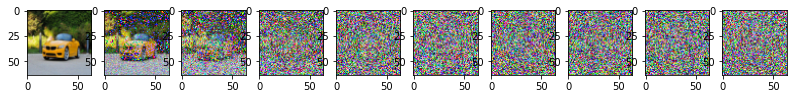

In [15]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

## Шаг 2: Обратный процесс = U-Net

С точки зрения архитектуры, авторы DDPM выбрали **U-Net**, представленный ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597 )) (который в то время достигал самых современных результатов в сегментации медицинских изображений). Эта сеть, как и любой автоэнкодер, состоит из узкого места посередине, которое гарантирует, что сеть запоминает только самую важную информацию. Важно отметить, что он ввел остаточные соединения между кодером и декодером, значительно улучшив градиентный поток (вдохновленный ResNet в [He et al., 2015](https://arxiv.org/abs/1512.03385)).

**Основные рекомендации**:
- Мы используем простую форму UNet для прогнозирования шума на изображении
     - Входное изображение с шумом, выходное - шум в изображении
- Поскольку параметры являются общими во времени, нам нужно сообщить сети, в каком временном интервале мы находимся
- Временной шаг кодируется синусоидальным вложением трансформатора
- Мы выводим одно единственное значение (среднее), потому что дисперсия фиксирована

In [13]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

### Position embeddings

Поскольку параметры нейронной сети являются общими во времени (уровень шума), авторы используют вложения синусоидального положения для кодирования $ t$, вдохновленные трансформатором ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762 )). Это позволяет нейронной сети "знать", на каком конкретном временном шаге (уровне шума) она работает для каждого изображения в пакете.

Модуль `SinusoidalPositionEmbeddings` принимает тензор формы `(batch_size, 1)` в качестве входных данных (т.е. уровни шума нескольких зашумленных изображений в пакете) и преобразует его в тензор формы `(batch_size, dim)`, где `dim` является размерностью вложений положения.. Затем это добавляется к каждому остаточному блоку, как мы увидим далее.

In [14]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### Simple Unet

In [17]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [18]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62438883


**Дальнейшие улучшения, которые могут быть реализованы:**
- Residual connections
- Different activation functions like SiLU, GWLU, ...
- BatchNormalization 
- GroupNormalization
- Attention
- ...

## Шаг 3: функция потерь



**Основные рекомендации:**
- После некоторых математических вычислений мы получаем очень простую функцию потерь
- Есть и другие возможные варианты, такие как потеря L2 и т.д.

In [19]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling

Поскольку мы будем использовать выборку из модели во время обучения (чтобы отслеживать прогресс), мы определяем код для этого ниже. Выборка обобщена в документе как алгоритм 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7 " width="500"/>

Генерация новых изображений из диффузионной модели происходит путем обращения процесса диффузии вспять: мы начинаем с $T$, где мы отбираем чистый шум из гауссовского распределения, а затем используем нашу нейронную сеть для постепенного уменьшения шума (используя изученную условную вероятность), пока мы не окажемся на временном шаге $t = 0$. Как показано выше, мы можем получить изображение с чуть меньшим шумом $\mathbf{x}_{t-1}$, подключив репараметризацию среднего значения, используя наш предиктор шума. Помните, что разница известна заранее.

В идеале мы получаем изображение, которое выглядит так, как будто оно взято из реального распределения данных.

Приведенный ниже код реализует это.

- Без добавления @torch.no_grad() у нас быстро заканчивается память, потому что pytorch привязывает все предыдущие изображения для вычисления градиента 
- Поскольку мы предварительно рассчитали отклонения шума для прямого прохода, мы также должны использовать их, когда последовательно выполняем обратный процесс

In [20]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

    
@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

Epoch 0 | step 000 Loss: 0.21981239318847656 


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
/var/folders/tm/8y1pdv8929z52bhjsbz6r18c0000gn/T/ipykernel_80705/2643972770.py:41: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(1, num_images, i/stepsize+1)


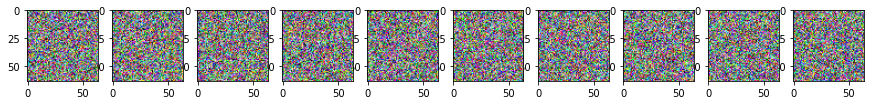

In [ ]:
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()